# Exploration

In [1]:
import pandas as pd

Dementia = pd.read_csv("dementia_dataset.csv")

In [2]:
Dementia.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


* can swap gender, handedness for a binary. 

In [3]:
# Swap the M/F feature for gender, and replace with binary. Swap out handedness for binary and group for binary
data = Dementia.copy()
data.rename(columns = {"M/F":"Gender"}, inplace = True)
data["Gender"].replace(to_replace = {"M":0, "F":1}, inplace = True)
data["Hand"].replace(to_replace = {"R":0, "L":1}, inplace = True)

In [4]:
first = data[data["Visit"]==1]

* I'm going to use a dataset with all rows, and a different set for only the first visit, so we can minimize the repetitions of the data. 
* We should drop the visit feature as well. I don't think it needs to be part of the model. 

* need to impute some data in SES and MMSE

In [5]:
# start with looking at the MMSE NaN values
data[data["MMSE"].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,Gender,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,1,0,75,12,NaN,NaN,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,1,0,77,12,NaN,NaN,1.0,1159,0.733,1.515


* It's visit 2 and 3 of the same patient.  

In [6]:
# Fixing the second and third visit for the MMSE NaN by simply setting them equal to the value of the first visit. 
data["MMSE"][357] = data["MMSE"][356]
data["MMSE"][358] = data["MMSE"][356]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   Gender      373 non-null    int64  
 6   Hand        373 non-null    int64  
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        373 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(7), object(3)
memory usage: 43.8+ KB


C:\Users\brett\AppData\Local\Temp\ipykernel_7072\338463907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MMSE"][357] = data["MMSE"][356]
C:\Users\brett\AppData\Local\Temp\ipykernel_7072\338463907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MMSE"][358] = data["MMSE"][356]


In [7]:
# imputing the data with the median of every other unique patient. 
frame = data[data["SES"].isna()]["SES"]
med = data[~data["SES"].isna() & data["Visit"]==1]["SES"].median()
for i in frame.index: 
    data["SES"][i] = med


C:\Users\brett\AppData\Local\Temp\ipykernel_7072\2625316358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SES"][i] = med


* we now have no null values. 
* My own predictions: 
    - I am worried that the MR Delay will have a large positive correlation with dementia. I don't have a definition, but judging from the data, it looks like MR Delay is a length of time after the first MRI
    - I think the number of visits will have a slight to medium correlation with the group.  People tend to get more MRI screenings to see how much the dementia has increased. 
    - I'm going to run models on two different datasets, one where we only use the first visits and one where we use all available data.  My concern is that patients with more visits will end up having a higher weight than those with fewer visits. 
    

# Univariate Analysis

## Full Data

In [8]:
# looking at whole data set statistics
data.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Subject ID,373,150,OAS2_0070,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRI ID,373,373,OAS2_0001_MR1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Group,373,3,Nondemented,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Visit,373.0,NaN,NaN,NaN,1.882038,0.922843,1.0,1.0,2.0,2.0,5.0
MR Delay,373.0,NaN,NaN,NaN,595.104558,635.485118,0.0,0.0,552.0,873.0,2639.0
Gender,373.0,NaN,NaN,NaN,0.571046,0.495592,0.0,0.0,1.0,1.0,1.0
Hand,373.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Age,373.0,NaN,NaN,NaN,77.013405,7.640957,60.0,71.0,77.0,82.0,98.0
EDUC,373.0,NaN,NaN,NaN,14.597855,2.876339,6.0,12.0,15.0,16.0,23.0
SES,373.0,NaN,NaN,NaN,2.436997,1.109307,1.0,2.0,2.0,3.0,5.0


* Converted refers to patients who were initially non-demented and became demented at a later visit. (https://www.kaggle.com/code/deepak525/dementia-classification-compare-classifiers)
    - depending on what we are trying to do here, we can classify converted as demented or non-demented.
    - for the purposes of this analysis, I am looking for precursors for dementia, so I may classify them as demented after the bivariate analysis. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


MMSE


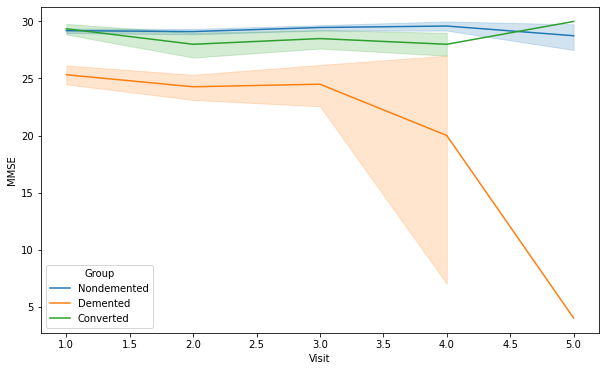

CDR


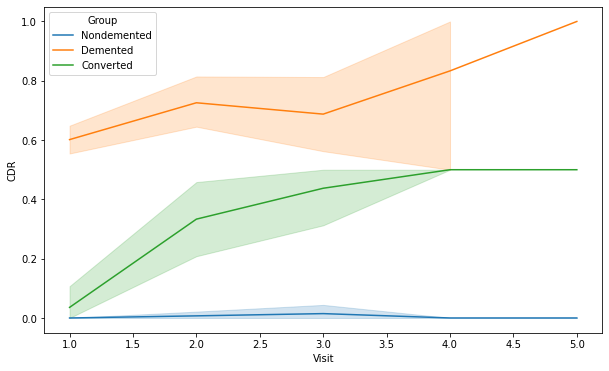

nWBV


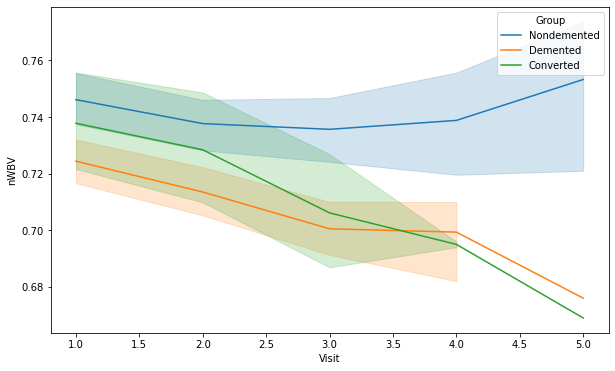

In [10]:
for col in ['MMSE','CDR','nWBV']:
    print(col)
    plt.figure(figsize=(10,6))
    sns.lineplot(x = data["Visit"], y = data[col], hue = data["Group"])
    plt.show()

* The important graph here is the first one measuring MMSE. MMSE is part of the diagnosis tools that doctors have to diagnose dementia. We see clear lines between nondemented and demented people. Even as the patients reach the 3rd and 4th visits patients slipping into dementia is pretty well separated from non demented individuals. 
* We also see that the estimated total intracranial volume is roughly the same. Note: this dataset only has 150 unique patients.  
* Note that the normalized Whole Brain Volume (nWBV) decreases for demented and converted patients, while it remains relatively consistent for nondemented patients. 

Age
Skew: 0.14


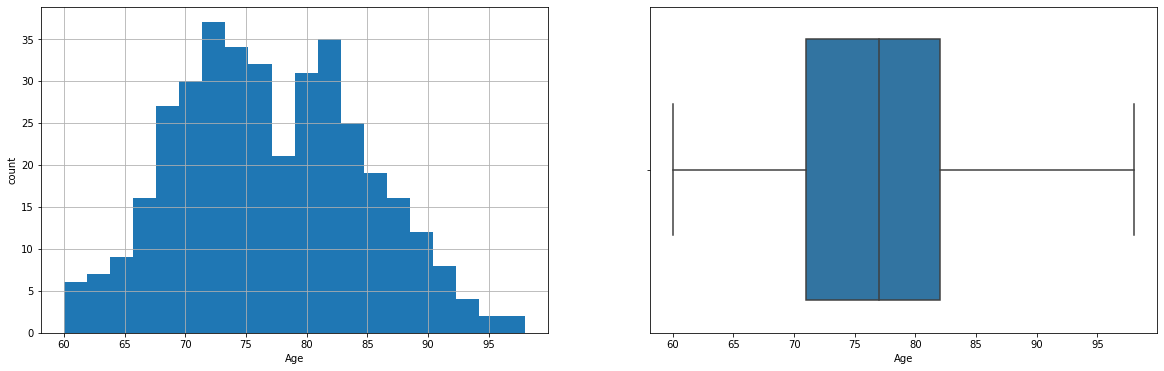

EDUC
Skew: -0.03


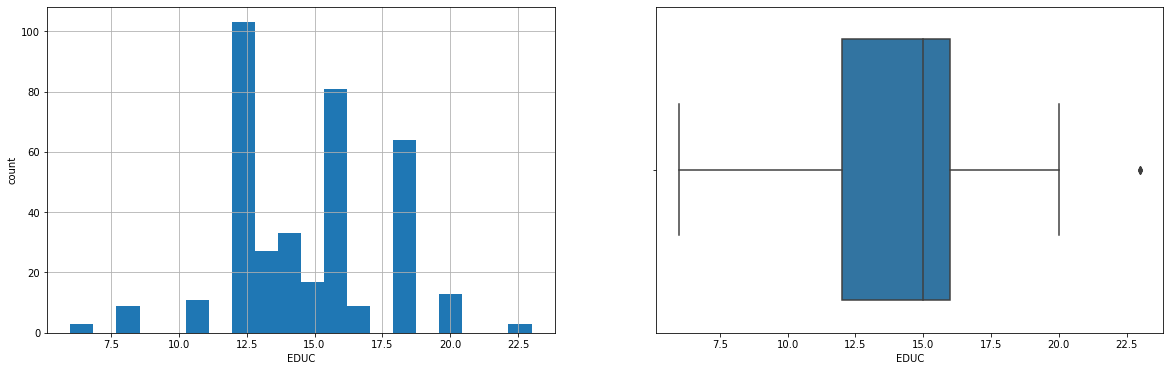

MMSE
Skew: -2.36


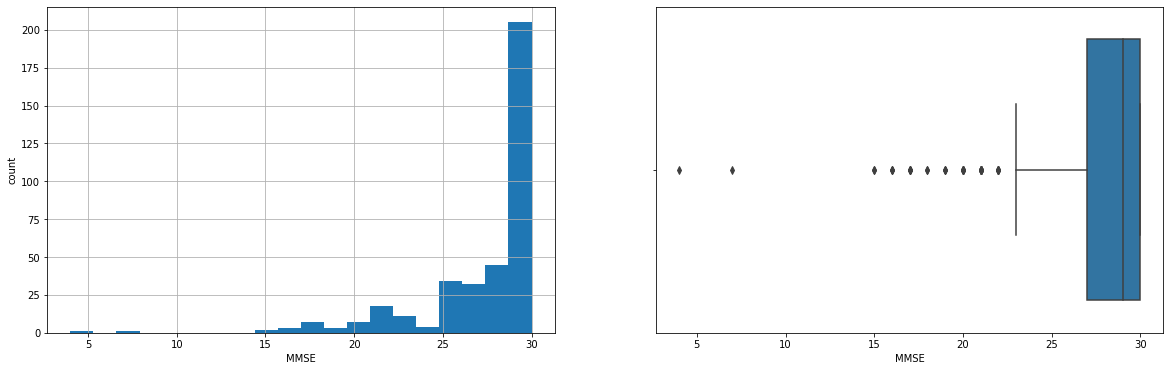

eTIV
Skew: 0.5


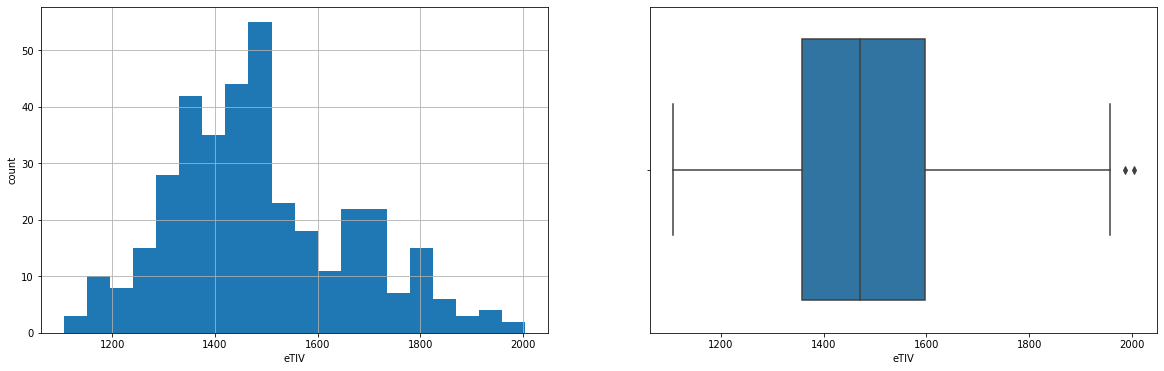

nWBV
Skew: 0.23


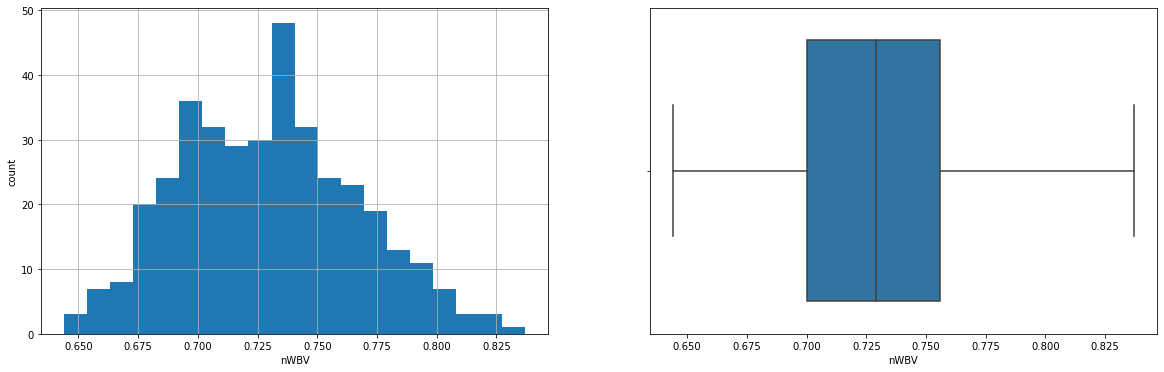

ASF
Skew: 0.08


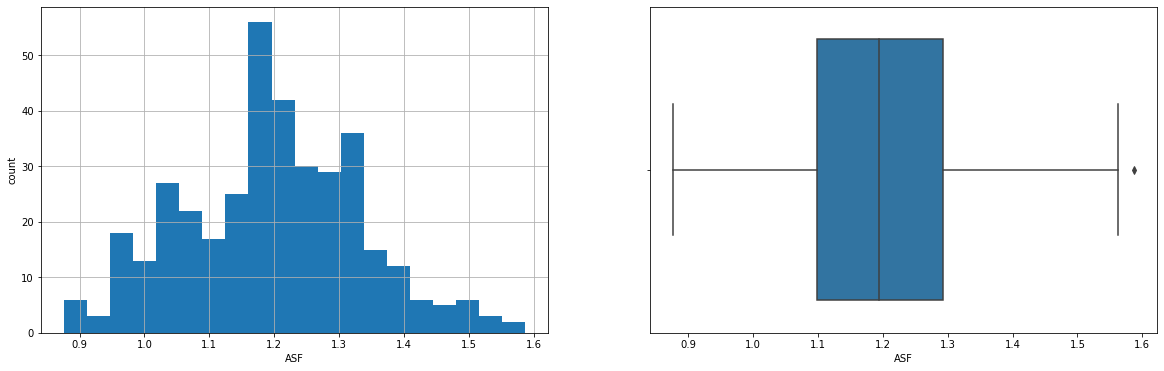

In [11]:
for col in ['Age','EDUC','MMSE', 'eTIV', 'nWBV', 'ASF']: 
    print(col)
    print(f'Skew: {round(data[col].skew(),2)}')
    plt.figure(figsize = (20,6))
    plt.subplot(1,2,1)
    data[col].hist(bins = 20)
    plt.ylabel("count")
    plt.xlabel(col)
    plt.subplot(1,2,2)
    sns.boxplot(x = data[col])
    plt.show()

* MMSE (Mini Mental State Examination) skewed left since the nondemented people will do well on this (half the dataset)
* For other features, we would expect to see roughly normal curves, but we have only 150 patients, so the skews are not surprising. 

# Bivariate Analysis. 

## Full Data

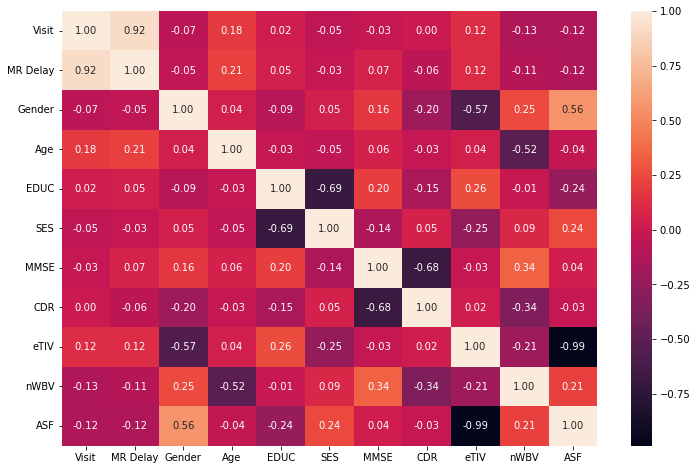

In [12]:
plt.figure(figsize = (12,8))
sns.heatmap(data = data.drop(["Hand"], axis = 1).corr(), annot = True, fmt = '.2f')
plt.show()

* 1-1 correlation with eTIV and ASF.  ASF is used to help find the estimate eTIV
* men have higher eTIV. 
* I don't have a metric for how socioeconomic status (SES) is measured. It looks like a lower number, the higher the class. At least that would make sense with respect to the relationship between SES and EDUC.  More education means higher status. 

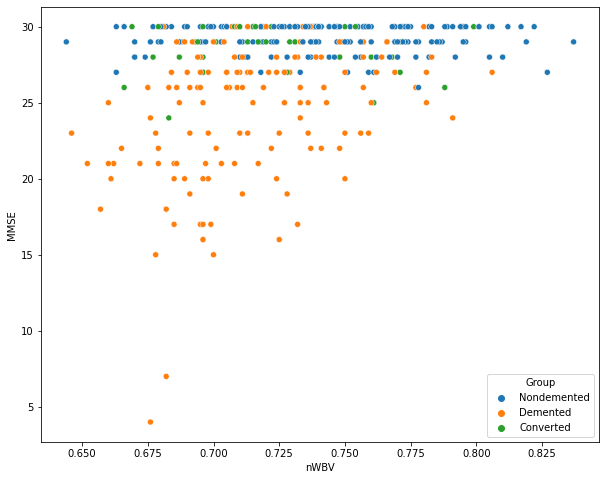

In [13]:
# I want a closer look at the nWBV and MMSE and how they are related with respect to the group. 

plt.figure(figsize = (10,8))
sns.scatterplot(data = data, y = "MMSE", x = "nWBV", hue = "Group")
plt.show()


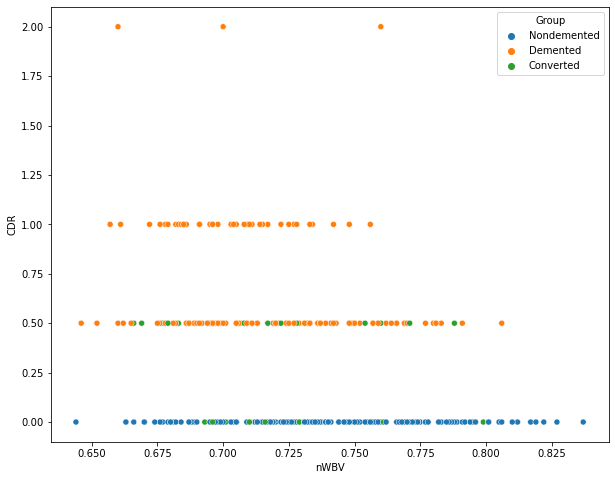

In [14]:
plt.figure(figsize = (10,8))
sns.scatterplot(data = data, x = "nWBV", y = "CDR", hue = "Group")
plt.show()

# Models

In [15]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn import metrics

#modified code from Data Science Online Courses. 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8,5))
    sns.heatmap(data = cm, annot = True, fmt = '.2f', xticklabels = ['Not Demented', 'Demented'], yticklabels = ['Not Demented', 'Demented'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Full Dataset

In [16]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Gender,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,0,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,0,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,0,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,0,0,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,0,0,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [17]:
# Drop id columns and convert group to binary. (converted will act as demented since that is how they end up)
data["Group"] = data["Group"].replace({"Nondemented":0, "Demented":1, "Converted":1})
data.drop(["Subject ID", "MRI ID", "Hand", "Visit"], inplace = True, axis = 1)

### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

G = data["Group"]
X = data.drop(["Group"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, G, test_size = .25, random_state = 1)

In [19]:
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       139

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



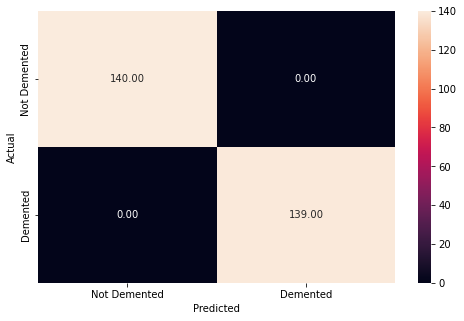

In [20]:
# Accuracy on training set
y_pred_train = d_tree.predict(X_train)
metrics_score(y_train, y_pred_train)

* This is expected, and certainly overfit. 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        50
           1       0.89      0.91      0.90        44

    accuracy                           0.90        94
   macro avg       0.90      0.90      0.90        94
weighted avg       0.90      0.90      0.90        94



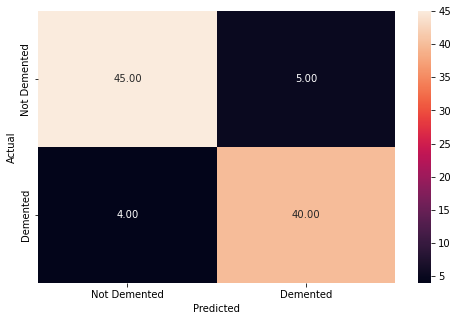

In [21]:
# accuracy on test set
y_pred_test = d_tree.predict(X_test)
metrics_score(y_test, y_pred_test)

* Not terrible.  However, the data that is collected here is the same patients used multiple times. 
* I think what is happening is that the test set consists of patients that the model is trained on.  Therefore, matching features of the same patients, and thus boosting the accuracy rating. 

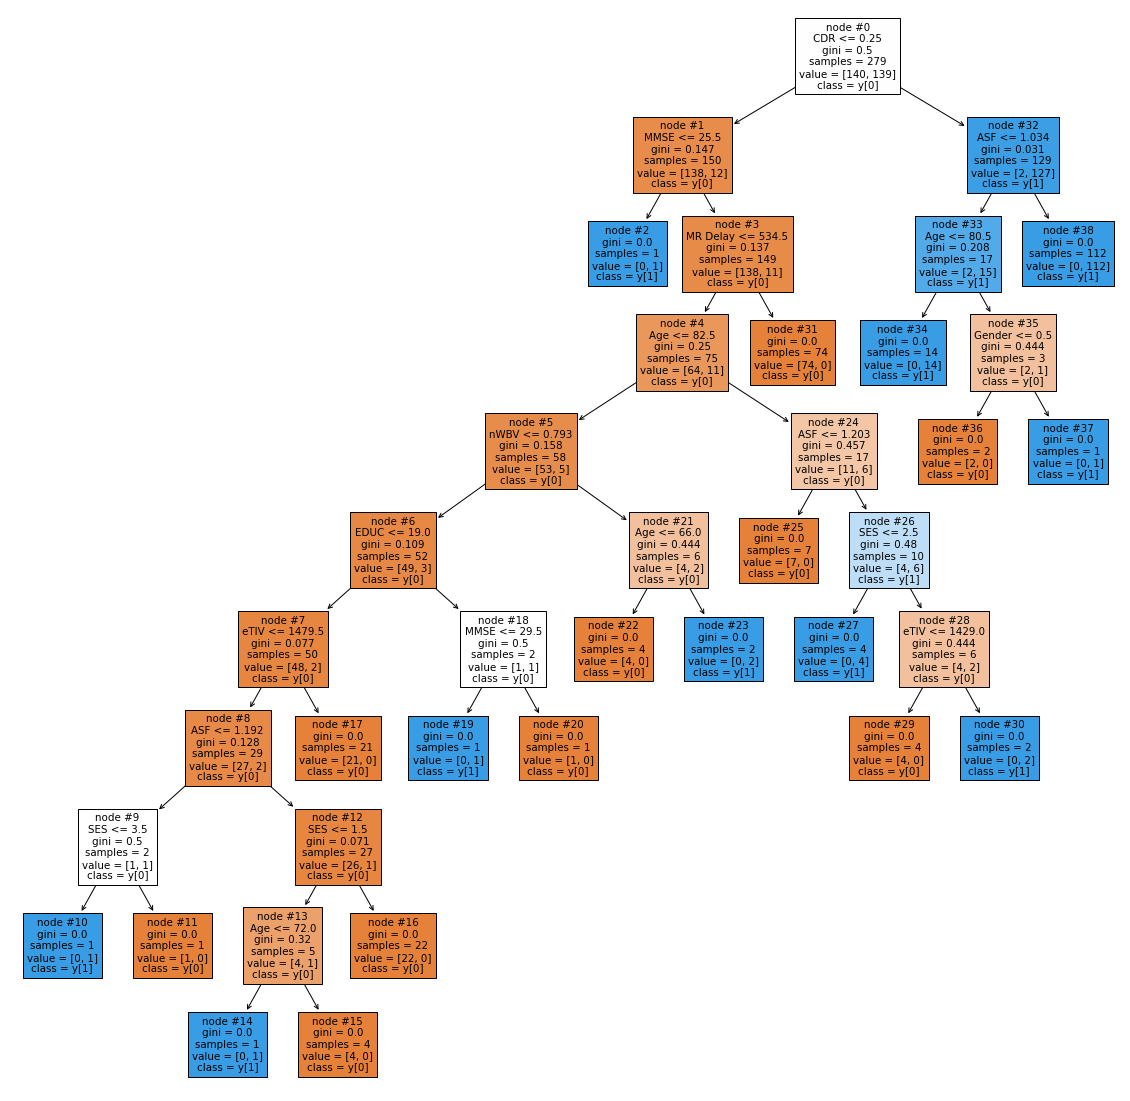

In [22]:
feat = list(X.columns)

plt.figure(figsize = (20,20))
tree.plot_tree(d_tree, feature_names = feat, filled = True, node_ids = True, class_names = True)
plt.show()

* Clearly this tree is overfit. We need to prune it. 


In [23]:
from sklearn.model_selection import GridSearchCV

# try to prune the tree, so that it fits information for a broader population than these sets. 
d_tree_tune = DecisionTreeClassifier(random_state = 1, class_weight = "balanced")

parameters = {'max_depth': np.arange(2,5), 
              'criterion':['gini', 'entropy'], 
              'min_samples_leaf':[5,7,9,11,13,15]}

grid_obj = GridSearchCV(d_tree_tune, parameters, scoring = "accuracy", cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

d_tree_tuned = grid_obj.best_estimator_
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=5,
                       random_state=1)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       140
           1       0.98      0.91      0.95       139

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



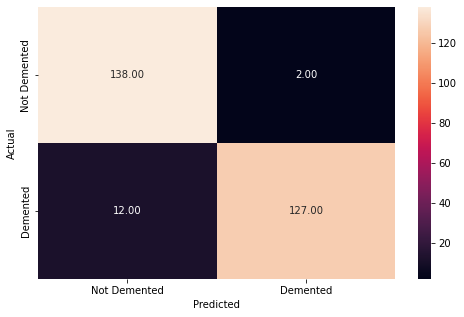

In [24]:
y_pred_train = d_tree_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

* 95% isn't bad. a few more patients are predicted not demented when they are actually demented. 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        50
           1       1.00      0.86      0.93        44

    accuracy                           0.94        94
   macro avg       0.95      0.93      0.94        94
weighted avg       0.94      0.94      0.94        94



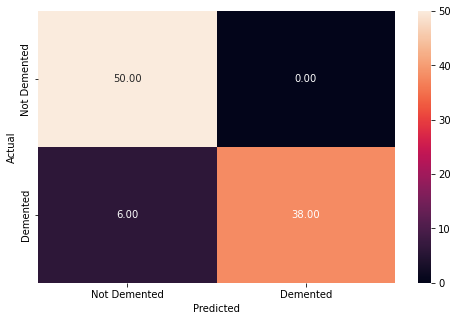

In [25]:
y_pred_test = d_tree_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

* same results as the training set. 
* Note that dementia is a bit subjective.  Memory is going to be inconsistant day to day.  Memory exams my have results that vary. 

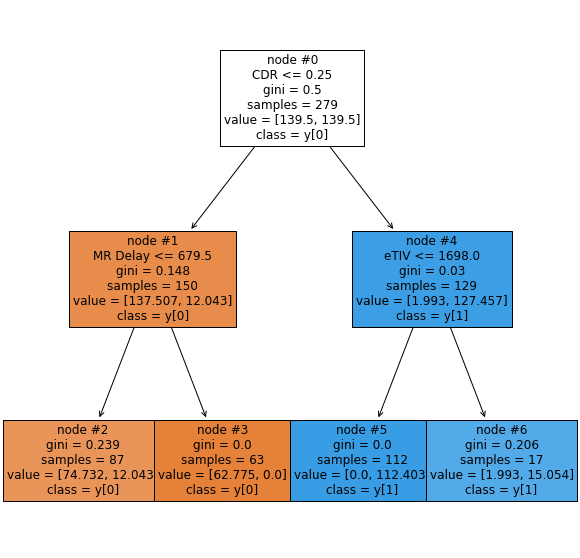

In [26]:
feat = list(X_train.columns)

plt.figure(figsize = (10,10))
tree.plot_tree(d_tree_tuned, feature_names = feat, filled = True, node_ids = True, class_names = True, fontsize = 12)
plt.show()

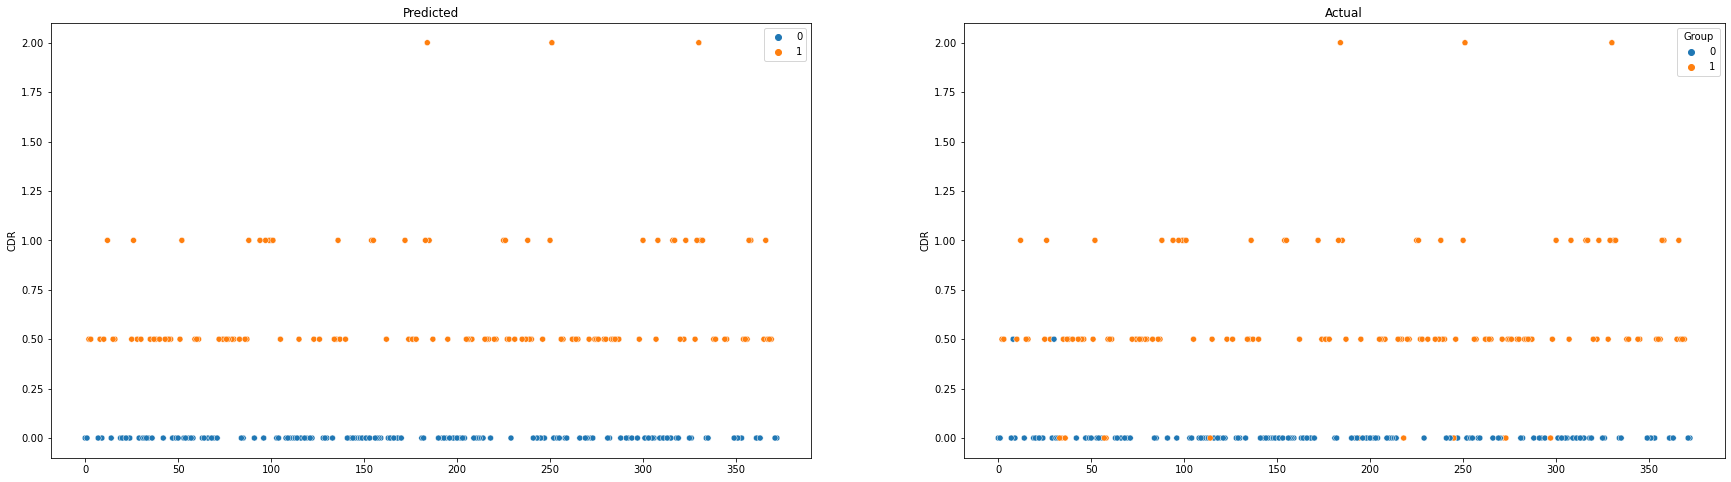

In [27]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_train).set_title("Actual")
plt.show()

* The model is separating based on CDR first. 
* Note that we set Converted to Dementia in these models, so some of the predictions may show incorrect when in fact they are correct. For instance, I would expect some of the data points with 0 CDR to actually have no dementia. 

### Random Forest Ensemble

In [28]:
rf = RandomForestClassifier(class_weight = "balanced")

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       139

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



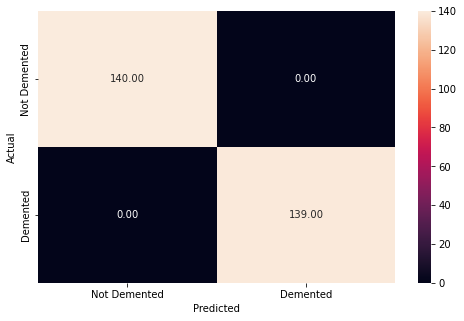

In [29]:
y_pred_train = rf.predict(X_train)
metrics_score(y_train, y_pred_train)

* likely overfit, next thing we do is check the test set. 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        50
           1       1.00      0.86      0.93        44

    accuracy                           0.94        94
   macro avg       0.95      0.93      0.94        94
weighted avg       0.94      0.94      0.94        94



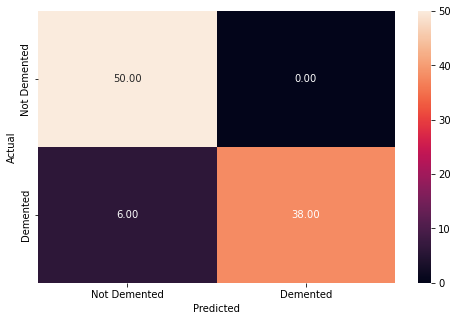

In [30]:
y_pred_test = rf.predict(X_test)
metrics_score(y_test, y_pred_test)

* not bad. I would expect this model to do worse on the dataset with first visits only.  
* We still need to note, that many of the data points are the same patients, so the points are actually weighted differently. 

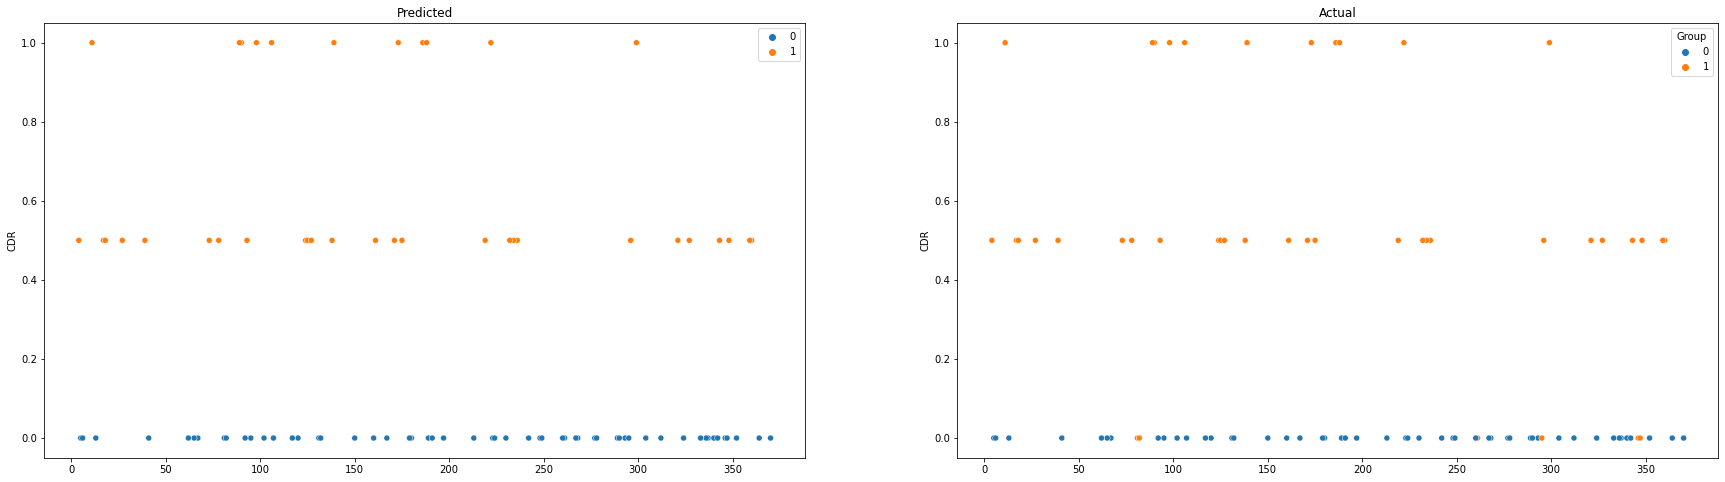

In [31]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_test).set_title("Actual")
plt.show()

* The ensemble might do better than the tree in this dataset. 

In [32]:
# tune the random forest

rf_tuned = RandomForestClassifier(class_weight = "balanced", random_state = 1)

parameters = {"n_estimators": [5,10,15,20,25,30],
              "max_depth": [4,5,6,7],
              "max_features":[.9,1],
              "criterion": ["gini","entropy"], 
              "min_samples_leaf":[1,2,3]}

grid = GridSearchCV(rf_tuned, parameters, scoring = "accuracy", cv = 5)
grid = grid.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=0.9, min_samples_leaf=3,
                       n_estimators=20, random_state=1)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       140
           1       0.98      0.94      0.96       139

    accuracy                           0.96       279
   macro avg       0.97      0.96      0.96       279
weighted avg       0.97      0.96      0.96       279



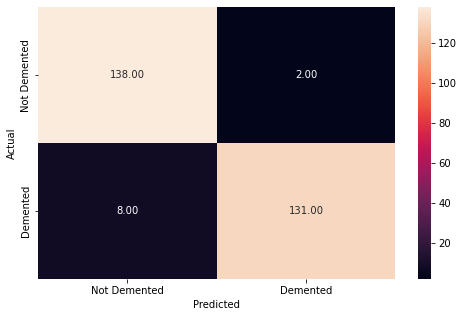

In [33]:
y_pred_train = rf_tuned.predict(X_train)
metrics_score(y_train, y_pred_train)

* Note again that there are some data points that are miscategorized. 
* This looks like it isn't overfit.  We will see in next cell. 

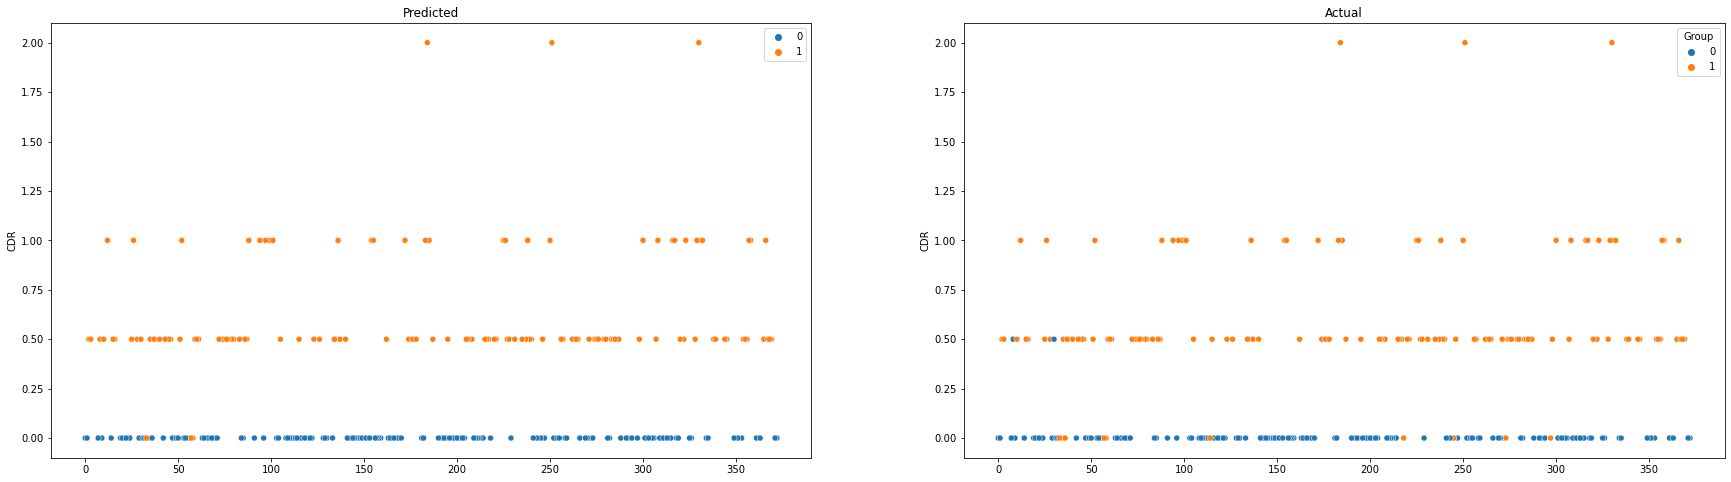

In [34]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_pred_train).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_train.index, y = X_train["CDR"], hue = y_train).set_title("Actual")
plt.show()

* Correctly catagorizing some of the data points with a 0 CDR. 
* Possible with more trees in the forest we might be able to get some more of those data points correctly predicted. 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.89      0.94        44

    accuracy                           0.95        94
   macro avg       0.95      0.94      0.95        94
weighted avg       0.95      0.95      0.95        94



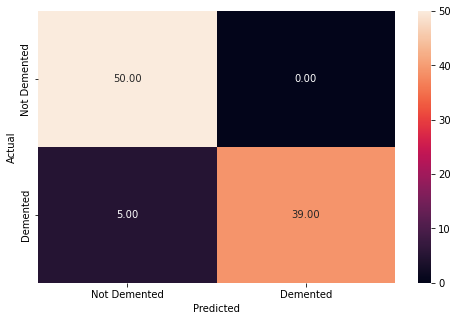

In [35]:
y_pred_test = rf_tuned.predict(X_test)
metrics_score(y_test, y_pred_test)

* Same results as test set. 
* It is comparable to the decision tree. 

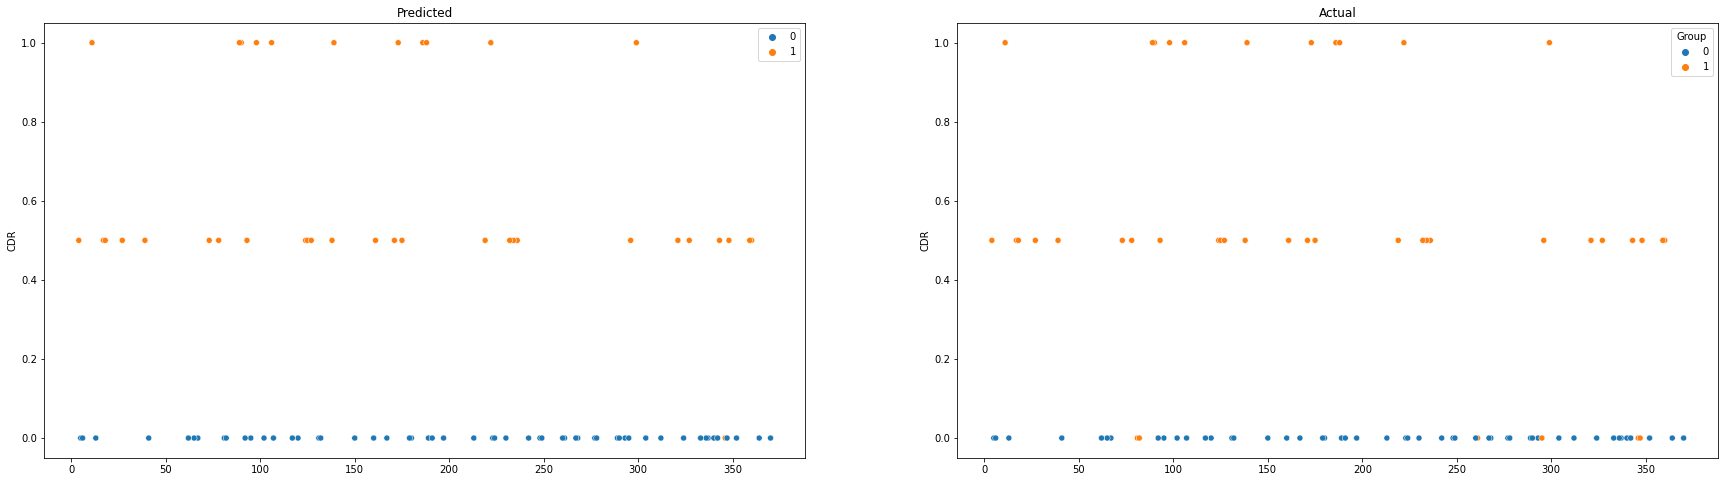

In [36]:
plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_pred_test).set_title("Predicted")
plt.subplot(1,2,2)
sns.scatterplot(x = X_test.index, y = X_test["CDR"], hue = y_test).set_title("Actual")
plt.show()

* PROGRESS: We correctly predicted one of the data points with a 0 CDR. 

### Notes on dataset
* With respect to the dataset limited to the first visit, there aren't enough data points to be able to come away with any meaningful data. 
* The whole dataset weights patients differently based on how many visits they had. 
* This process would be more meaningful if the data didn't have a "converted" status. 